In [19]:
import numpy as np
import pandas as pd
import random as rn
import sklearn
from sklearn import metrics
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gagga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gagga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"}) # We rename the columns
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
#phrase_data = dic[["ID"], ["feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
dic.insert(2, "sentiment", y)

phrase_data = dic.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.head())

       feature  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0


In [68]:
#data preprossing

filler_words = set(stopwords.words('english'))

#values =[[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
to_drop=[]


# relabel sentiment with corresponding sentiment + drop sentiment column
for i in range (phrase_data.shape[0]):
    if (phrase_data["sentiment"][i]<=0.2):
        phrase_data["label"][i]=0
    if (phrase_data["sentiment"][i]>0.2) and (phrase_data["sentiment"][i]<=0.4):
        phrase_data["label"][i]=1
    if (phrase_data["sentiment"][i]>0.4) and (phrase_data["sentiment"][i]<=0.6):
        phrase_data["label"][i]=2
    if (phrase_data["sentiment"][i]>0.6) and (phrase_data["sentiment"][i]<=0.8):
        phrase_data["label"][i]=3
    if (phrase_data["sentiment"][i]>0.8) and (phrase_data["sentiment"][i]<=1):
        phrase_data["label"][i]=4

    # 'clean' phrases: remove numbers, punctuation and filler words
    phrase = phrase_data["feature"][i]
    cleaned = re.sub(r'[^\w]', ' ', phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', ' ',cleaned)  #remove all numbers 
    if (cleaned.replace(" ","")==""):
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #tokenise for bag of words
        cleaned = [w for w in cleaned if w not in filler_words] # #remove all filler words
    phrase_data["feature"][i]= cleaned 

# remove unnecessary data
phrase_data.drop("sentiment",axis=1,inplace=True) 
phrase_data.drop(to_drop,axis=0,inplace=True)
df = phrase_data[~phrase_data.astype(str).duplicated()]
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)
print(df.head())


#save this as file - takes 13 mins to run
df.to_pickle("clean_phrase_data.pkl") 


<ipython-input-68-b138a3be6285>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_data["label"][i]=2
<ipython-input-68-b138a3be6285>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_data["feature"][i]= cleaned
<ipython-input-68-b138a3be6285>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_data["label"][i]=4
<ipython-input-68-b138a3be6285>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

       feature  label
3       [alas]      2
4  [brilliant]      4
5  [brilliant]      4
6  [brilliant]      4
7     [c, mon]      2


In [118]:
# convert phrases to numerical representation: bag of words
phrase_data = pd.read_pickle("clean_phrase_data.pkl") 

#split phrase datasets to x and y
X = phrase_data["feature"].copy()
y = phrase_data["label"].copy()


#create word vector 
vectorizer = CountVectorizer()
vectorizerfit = vectorizer.fit_transform(X.astype(str))
names = vectorizer.get_feature_names()
count_array = vectorizerfit.toarray()
vec = pd.DataFrame(data=count_array,columns=names)


0         1
1         1
2         1
3         3
4         7
         ..
152013    2
152014    7
152015    1
152016    0
152017    3
Length: 152018, dtype: int64


In [ ]:
#feature importance

In [120]:
#split test and train
x_train, x_test, y_train, y_test = train_test_split(vec, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(106412, 17719) (45606, 17719) (106412,)


In [122]:
#naive bayes
clf = MultinomialNB()
clf.fit(x_train,y_train)
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.6085497876179379
0.5052405385256326


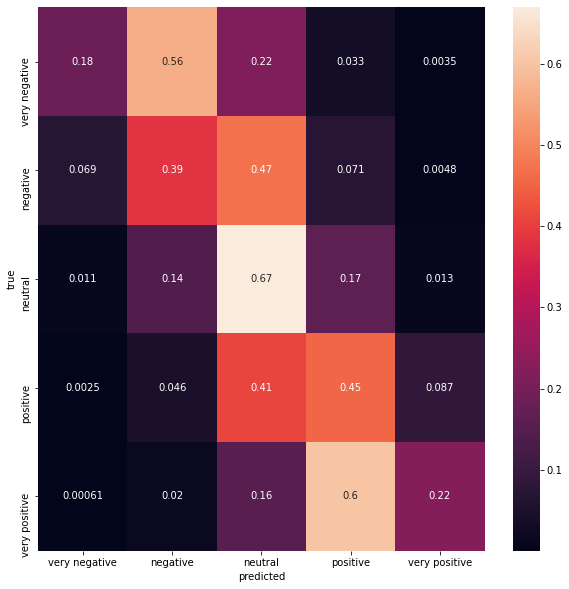

In [125]:
#above not great, maybe add in a regulariser?

#confusion matrix
matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

In [123]:
#random forest - grid search for optimal decision tree parameters -maybe try dif criterion
rf_dic={
    "n_estimators":[10,50,200,500],
    "max_features": ["sqrt","log2"],
    "criterion": ["gini"],
    "max_depth": [4,8,30]
    }

rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
grid_search.fit(x_train,y_train)

print("the best parameters are: " +str(grid_search.best_params_))

print("accuracy: " + str(grid_search.best_estimator_.score(x_test, y_test)*100) + "%")


the best parameters are: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 10}
accuracy: 45.00942858395825%


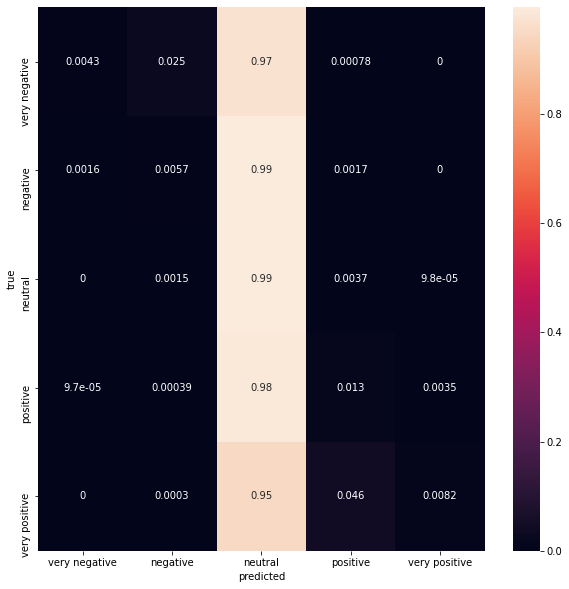

In [124]:
#confusion matrix
matrix = confusion_matrix(y_test,grid_search.best_estimator_.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

In [ ]:
#log reg. #nn